# Data Analysis Interview Challenge (Ultimate Inc.)

In [1]:
# Managing warnings
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import math

import json
from pandas.io.json import json_normalize

# Plot the Figures Inline
%matplotlib inline

In [2]:
## display option
pd.set_option('display.max_columns', None)

In [3]:
## missing values
missing_values = ['n/a', 'na', '-', '*']

# Part 1. Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [4]:
#timestamps of user logins in a particular geographic location
df_logins = pd.read_json('data/logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_logins.shape

(93142, 1)

In [6]:
print("min time: {}".format(df_logins.login_time.min()))
print("max time: {}".format(df_logins.login_time.max()))

min time: 1970-01-01 20:12:16
max time: 1970-04-13 18:57:38


In [7]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
#Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex for using resample(), NOT RangeIndex
df_logins = df_logins.set_index('login_time')

In [9]:
# aggregate login counts based on 15-minute time intervals
df_logins['count_fifteenMin'] = 0
df_logins = df_logins.resample('15min').count()
df_logins.head()

,count_fifteenMin
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
#DatetimeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
count_fifteenMin    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


In [11]:
df_logins = df_logins.reset_index()

In [12]:
#RangeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
login_time          9788 non-null datetime64[ns]
count_fifteenMin    9788 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.0 KB


Visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles.

### Seasonal

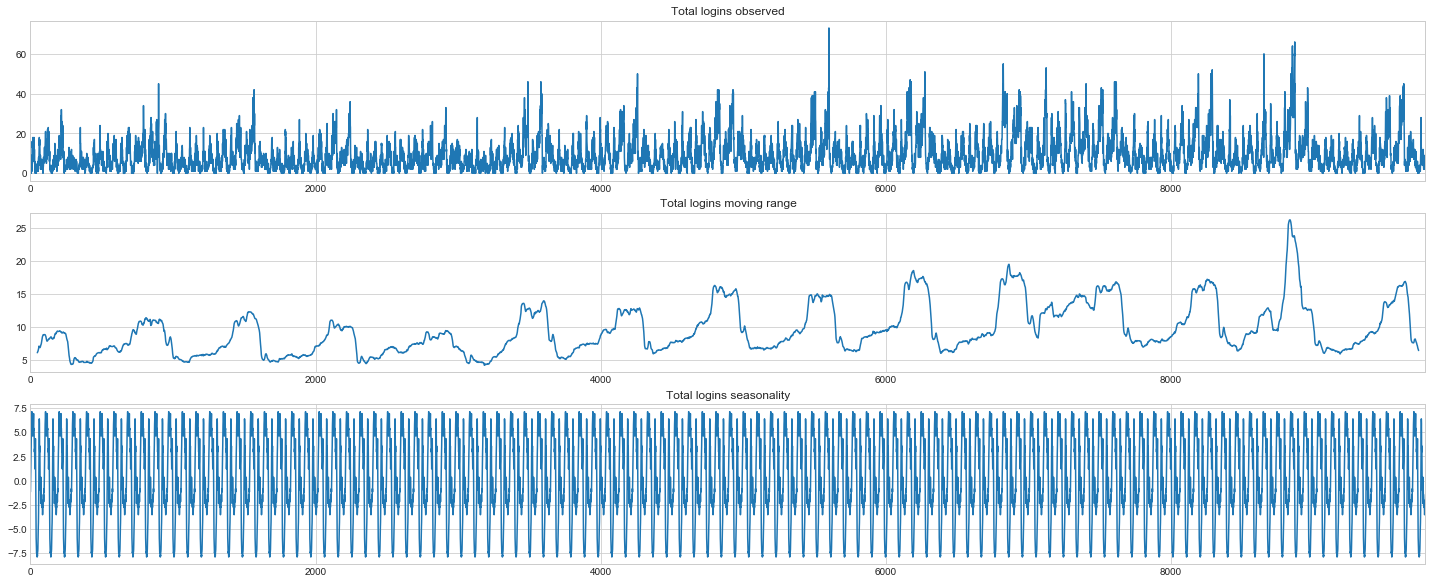

In [13]:
#Create a correlation plot of both datasets.
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 
season = seasonal_decompose(df_logins['count_fifteenMin'], model='additive', freq=96)

plt.subplot(3, 1, 1)
plt.title('Total logins observed')
season.observed.plot()

plt.subplot(3, 1, 2)
plt.title('Total logins moving range')
season.trend.plot()

plt.subplot(3, 1, 3)
plt.title('Total logins seasonality')
season.seasonal.plot()

It seems there are some patterns but it is hard to interpret. To look closer, the hourly and daily patterns of logins are investigated. 

### Week Day

In [14]:
# The day of the week with Monday=0, Sunday=6.
#df_logins['weekday']=df_logins['login_time'].dt.weekday #weekday = dayofweek (alias)
# names for ease of reference
#df_dayweek.weekday = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


df_logins['weekday']=df_logins['login_time'].dt.day_name() #weekday = dayofweek (alias)
df_logins.head()

,login_time,count_fifteenMin,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [15]:
# groupby('key', as_index=False): key does not become index but a column (no need reset_index() later)
df_dayweek = df_logins.groupby('weekday', as_index=False).sum()
df_dayweek

,weekday,count_fifteenMin
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins by Day of Week')

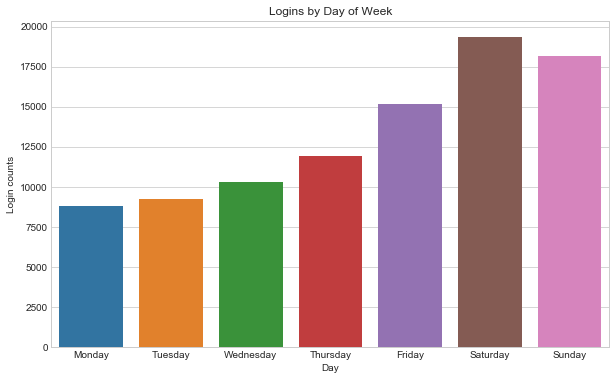

In [26]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,6)) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# bar plot
sns.barplot(x = 'weekday', y = 'count_fifteenMin', data = df_dayweek, order=weekday_order)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of Week')

In [17]:
df_logins['hour'] = df_logins['login_time'].dt.hour
df_logins.head()

,login_time,count_fifteenMin,weekday,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [18]:
df_hour = df_logins.groupby('hour', as_index=False).sum()
df_hour.head()

,hour,count_fifteenMin
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Logins by Hour')

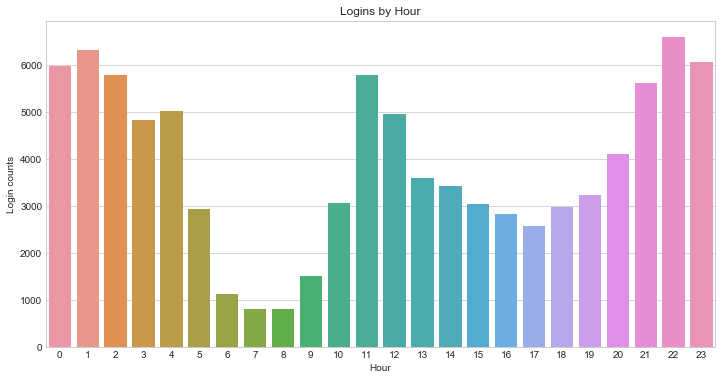

In [19]:
fig = plt.figure(figsize=(10,6))
# bar plot
sns.barplot(x = 'hour', y = 'count_fifteenMin', data = df_hour)
plt.xlabel('Hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

In [20]:
# def dateplot(x, y, **kwargs):
#     ax = plt.gca()
#     data = kwargs.pop("data")
#     data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
    
# g = sns.FacetGrid(df_logins, col="weekday", col_wrap=3, height=3.5)
# g = g.map_dataframe(dateplot, "hour", "count_fifteenMin")

In [21]:
df_day_hour = df_logins.groupby(['weekday','hour'], as_index=False).sum()
df_day_hour.head()

,weekday,hour,count_fifteenMin
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


* Pandas - How to group-by and plot for each hour of each day of week  
https://stackoverflow.com/questions/54856726/pandas-how-to-group-by-and-plot-for-each-hour-of-each-day-of-week

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x720 with 0 Axes>

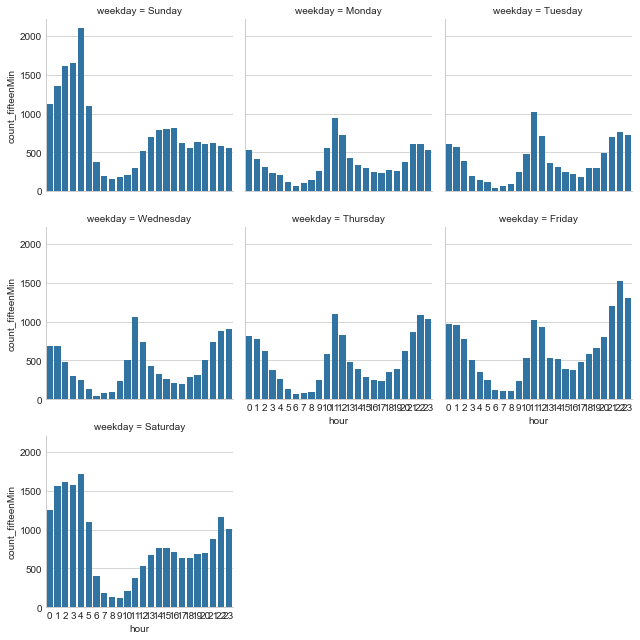

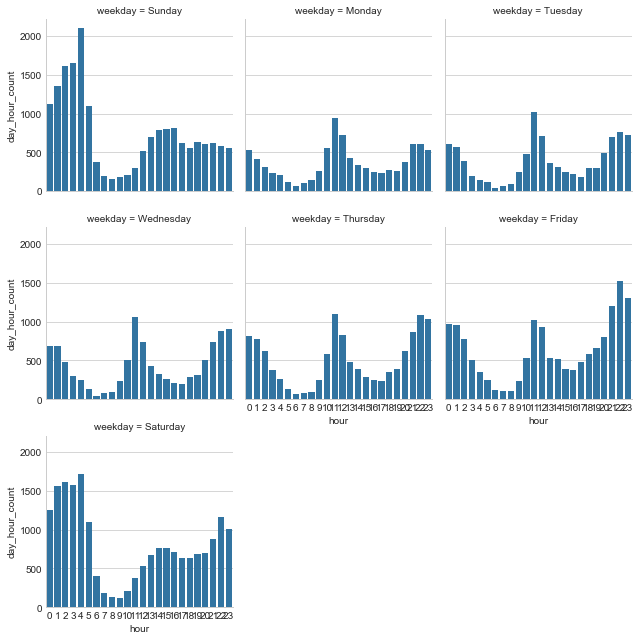

In [23]:
fig = plt.figure(figsize=(20,10))
g = sns.FacetGrid(df_day_hour, col="weekday", col_wrap=3, col_order=[
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
])
g.map(sns.barplot, "hour", "count_fifteenMin")

## exact same approach
# g = sns.FacetGrid(data=df_logins.groupby(['weekday','hour']).count_fifteenMin.sum()
#                   .to_frame(name='day_hour_count').reset_index(), 
#                   col='weekday', 
#                   col_order=[
#     'Sunday',
#     'Monday',
#     'Tuesday',
#     'Wednesday',
#     'Thursday',
#     'Friday',
#     'Saturday'
# ], col_wrap=3)
# g.map(sns.barplot, 'hour', 'day_hour_count')

==> Summary:  

The logins most occur in Saturday and Sunday.

By investigating into hours, logins most occur at late night and  (21 ~ 2).
The logins start to increase from 21, peak at 22, decrease after 1.
During the lunch time (11 ~ 12), logins increase for a while.

**Combining weekdays and hours, we can see that most users log in most of the late nights and dawns on Sundays and Saturdays.**

# Part 2. Experiment and Metrics Design

# Part 3. Predictive Modeling

# Reference

http://benalexkeen.com/resampling-time-series-data-with-pandas/  
https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/